# Solving separable non-linear problems with the Variable Projection method

@Author: Ettore Biondi - ebiondi@caltech.edu

In this notebook we are going to test and explore the variable projection method (Golub and Pereyra, 1973) on a simple exponential fitting problem. This kind of inverse problem falls into the set of separable non-linear problems; therefore, the variable-projection method (VarPro) can and should be applied. The analytical/modeling equation is represented by the following:
\begin{align}
y_{i} = a e^{-b t_{i}},
\end{align}
where $a$ and $b$ are the model parameters and $t_i$ indicates the $i$-th time sample. We are going to minimize the simple $L_{2}$ difference between the model and the observed data. Hence, we can write the objective function as the following:
\begin{align}
\phi(a,b) = \frac{1}{2} \|\mathbf{y}(a,b) - \mathbf{y}_{obs} \|_2^2.
\end{align}
We notice that this objective function is quadratic with respect to parameter $a$ and non-linear with respect to the other.

### Importing necessary libraries

In [1]:
import time
import numpy as np
import occamypy as o

# Plotting
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
rcParams.update({
    'image.cmap'     : 'jet',
    'image.aspect'   : 'auto',
    'image.interpolation': None,
    'axes.grid'      : True,
    'figure.figsize' : (10, 6),
    'savefig.dpi'    : 300,
    'axes.labelsize' : 14,
    'axes.titlesize' : 16,
    'font.size'      : 14,
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    'text.usetex'    : True,
    'font.family'    : 'serif',
    'font.serif'     : 'Latin Modern Roman',
})

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


/Users/francesco/miniconda3/envs/occd/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


### Defining non-linear modeling operator for symultaneous inversion
Here we define the model vector as $\mathbf{m}= [a,b]^{T}$

In [2]:
class ExpNL_Sym(o.Operator):

    def __init__(self, model, t_vec):
        """y(a,b;t) = a * exp(-b*t) """
        self.setDomainRange(model, t_vec)
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self, add, model, data):
        """Forward non-linear"""
        self.checkDomainRange(model, data)
        a = model[0]
        b = model[1]
        if not add: data.zero()
        data[:] += a * np.exp(-b*self.t_samples)
        return

class ExpNL_Sym_J(o.Operator):

    def __init__(self, model, t_vec):
        """Jacobian matrix of the non-linear exponential for symultaneous inversion"""
        super(ExpNL_Sym_J, self).__init__(model, t_vec)
        self.m0 = model.clone()
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self, add, model, data):
        """Forward jacobian"""
        self.checkDomainRange(model, data)
        da = model[0]
        db = model[1]
        a0 = self.m0[0]
        b0 = self.m0[1]
        if not add: data.zero()
        data[:] += da * np.exp(-b0*self.t_samples) - a0 * self.t_samples * db * np.exp(-b0*self.t_samples)
        return

    def adjoint(self, add, model, data):
        """Adjoint jacobian"""
        self.checkDomainRange(model, data)
        da = model[0]
        db = model[1]
        a0 = self.m0[0]
        b0 = self.m0[1]
        if not add: model.zero()
        model[0] += np.sum(data[:] * np.exp(-b0*self.t_samples))
        model[1] -= np.sum(data[:] * a0 * self.t_samples*np.exp(-b0*self.t_samples))
        return

    def set_m0(self,m0):
        self.m0.copy(m0)
        return

In [3]:
# Generating observed data
time_vec = o.VectorNumpy(np.linspace(0., 2., 200))
a_true = 10.0
b_true = 1.0
true_m = o.VectorNumpy(np.array([a_true, b_true]))

# modeling operator
M = ExpNL_Sym(true_m, time_vec)

# apply modeling operator
data_true = M * true_m

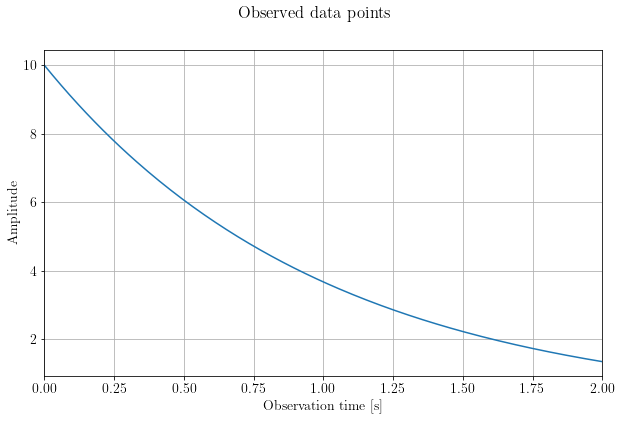

In [4]:
fig, ax = plt.subplots()
ax.plot(time_vec.plot(), data_true.plot())
ax.set_xlabel("Observation time [s]"), ax.set_ylabel("Amplitude")
ax.set_xlim(0,2)
plt.suptitle("Observed data points")
plt.show()

In [5]:
# Generating Jacobian of the non-linear operator
J = ExpNL_Sym_J(true_m, time_vec)
E = o.NonlinearOperator(M, J, J.set_m0)

# Instanciating non-linear problem
L2_sym = o.NonlinearLeastSquares(true_m, data_true, E)

In [6]:
#Computing the objective function for plotting
a_samples = np.linspace(0.0, 30.0, 500)
b_samples = np.linspace(-1.0, 6.0, 200)
obj_l2 = np.zeros((len(a_samples), len(b_samples)))

model_test = o.VectorNumpy((2,)).zero()

for ia, a_value in enumerate(a_samples):
    for ib, b_value in enumerate(b_samples):
        model_test[0] = a_value
        model_test[1] = b_value
        obj_l2[ia, ib] = L2_sym.get_obj(model_test)

Let's check the shape of the objective function

/var/folders/dt/5j82lw751s7_f33yv8l92zmc0000gn/T/ipykernel_15545/2136406565.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, label='$\phi(a,b)$', cax=divider.append_axes("right", size="2%", pad=0.1))


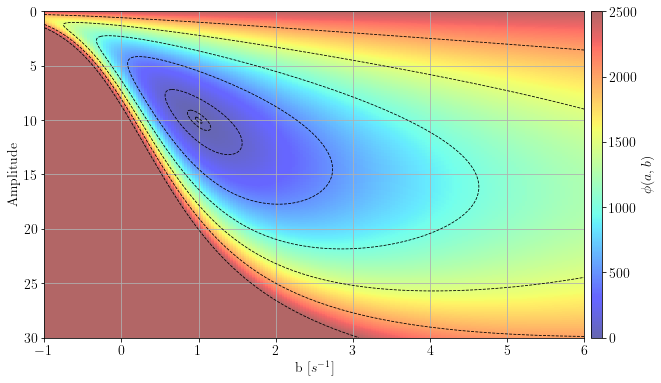

In [7]:
fig, ax = plt.subplots()

im = plt.imshow(obj_l2, clim=(0,2500), extent=[-1., 6., 30., 0.], alpha=.6)

ax.set_xlabel("b [$s^{-1}$]")
ax.set_ylabel("Amplitude")

cs = plt.contour(obj_l2,
                 levels=[1., 10., 100., 500., 1000., 1500., 2000., 2500.],
                 extent=[-1., 6., 0., 30.],
                 colors="black", linewidths=(.8,), linestyles='--')

divider = make_axes_locatable(ax)
cbar = plt.colorbar(im, label='$\phi(a,b)$', cax=divider.append_axes("right", size="2%", pad=0.1))

plt.show()

## Solve with Nonlinear Conjugate Gradient

In [8]:
NLCGsolver = o.NLCG(o.BasicStopper(niter=1000, tolr=1e-32, tolg=1e-32),
                    beta_type="FR")

model_init = model_test

a_initial, b_initial = 2., 0.

model_init[0] = a_initial
model_init[1] = b_initial

# Setting initial model
_ = L2_sym.get_obj(model_init)
L2_sym.setDefaults()
NLCGsolver.setDefaults(save_obj=True, save_model=True)
t0 = time.time()

NLCGsolver.run(L2_sym, verbose=True)

print("Computational time %s s" % (time.time() - t0))

objNLCG = np.copy(NLCGsolver.obj)

# Converting sampled points to arrays for plotting
a_smpld = []
b_smpld = []
for i in range(len(NLCGsolver.model)):
    a_smpld.append(NLCGsolver.model[i][0])
    b_smpld.append(NLCGsolver.model[i][1])

##########################################################################################
			NON-LINEAR CONJUGATE GRADIENT SOLVER 

	Restart folder: /tmp/restart_2022-04-16T18-14-16.160699/
	Conjugate method used: FR
##########################################################################################

iter = 0000, obj = 1.13543e+03, rnorm = 4.77e+01, gnorm = 6.04e+02, feval = 1, geval = 1
iter = 0001, obj = 9.96829e+02, rnorm = 4.47e+01, gnorm = 3.24e+02, feval = 4, geval = 2
iter = 0002, obj = 8.41188e+02, rnorm = 4.10e+01, gnorm = 1.30e+03, feval = 7, geval = 3
iter = 0003, obj = 7.44506e+01, rnorm = 1.22e+01, gnorm = 2.48e+02, feval = 10, geval = 4
iter = 0004, obj = 5.25159e+01, rnorm = 1.02e+01, gnorm = 8.37e+01, feval = 13, geval = 5
iter = 0005, obj = 5.01772e+01, rnorm = 1.00e+01, gnorm = 4.34e+01, feval = 16, geval = 6
iter = 0006, obj = 4.78102e+01, rnorm = 9.78e+00, gnorm = 1.03e+02, feval = 19, geval = 7
iter = 0007, obj = 3.51325e+01, rnorm = 8.38e+00, gnorm = 2.68e

iter = 0213, obj = 2.16280e-23, rnorm = 6.58e-12, gnorm = 2.65e-10, feval = 640, geval = 214
iter = 0214, obj = 9.58058e-24, rnorm = 4.38e-12, gnorm = 1.75e-10, feval = 643, geval = 215
iter = 0215, obj = 6.14413e-24, rnorm = 3.51e-12, gnorm = 7.53e-11, feval = 646, geval = 216
iter = 0216, obj = 5.56667e-24, rnorm = 3.34e-12, gnorm = 3.09e-11, feval = 649, geval = 217
iter = 0217, obj = 5.45387e-24, rnorm = 3.30e-12, gnorm = 1.70e-11, feval = 652, geval = 218
iter = 0218, obj = 5.40242e-24, rnorm = 3.29e-12, gnorm = 1.92e-11, feval = 655, geval = 219
iter = 0219, obj = 5.32371e-24, rnorm = 3.26e-12, gnorm = 2.90e-11, feval = 658, geval = 220
iter = 0220, obj = 4.61497e-24, rnorm = 3.04e-12, gnorm = 4.44e-11, feval = 661, geval = 221
iter = 0221, obj = 6.77332e-25, rnorm = 1.16e-12, gnorm = 3.85e-11, feval = 664, geval = 222
iter = 0222, obj = 1.11821e-26, rnorm = 1.50e-13, gnorm = 3.64e-12, feval = 667, geval = 223
iter = 0223, obj = 6.98043e-27, rnorm = 1.18e-13, gnorm = 5.83e-13, fe

Plot the optimization path

/var/folders/dt/5j82lw751s7_f33yv8l92zmc0000gn/T/ipykernel_15545/237955672.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, label='$\phi(a,b)$', cax=divider.append_axes("right", size="2%", pad=0.1))


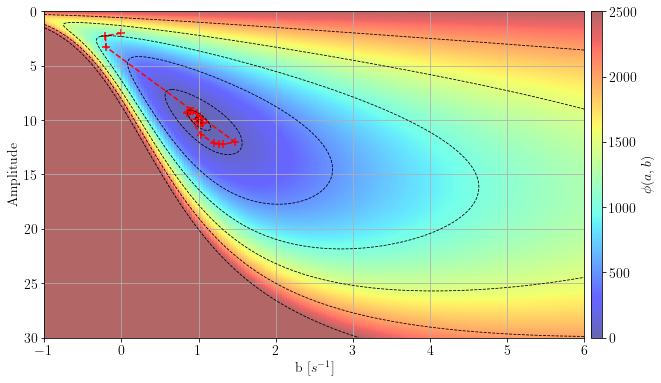

In [9]:
fig, ax = plt.subplots()

im = plt.imshow(obj_l2, clim=(0,2500), extent=[-1., 6., 30., 0.], alpha=.6)
ax.scatter(b_smpld ,a_smpld, color='red' ,s=50, marker="+")
ax.plot(b_smpld, a_smpld, "--", color='red')

ax.set_xlabel("b [$s^{-1}$]")
ax.set_ylabel("Amplitude")

cs = plt.contour(obj_l2,
                 levels=[1., 10., 100., 500., 1000., 1500., 2000., 2500.],
                 extent=[-1., 6., 0., 30.],
                 colors="black", linewidths=(.8,), linestyles='--')

divider = make_axes_locatable(ax)
cbar = plt.colorbar(im, label='$\phi(a,b)$', cax=divider.append_axes("right", size="2%", pad=0.1))

plt.show()

## Solve with BFGS

In [10]:
BFGSsolver = o.LBFGS(NLCGsolver.stopper)

# Setting initial model
_ = L2_sym.get_obj(model_init)
L2_sym.setDefaults()
BFGSsolver.setDefaults(save_obj=True, save_model=True)
t0 = time.time()

BFGSsolver.run(L2_sym, verbose=True)
objBFGS = np.copy(BFGSsolver.obj)

print("Computational time %s s" % (time.time() - t0))

# Converting sampled points to arrays for plotting
a_smpld = []
b_smpld = []
for i in range(len(BFGSsolver.model)):
    a_smpld.append(BFGSsolver.model[i][0])
    b_smpld.append(BFGSsolver.model[i][1])

##########################################################################################
			BFGS SOLVER 

	Restart folder: /tmp/restart_2022-04-16T18-14-16.641109/
##########################################################################################

iter = 0000, obj = 1.13543e+03, rnorm = 4.77e+01, gnorm = 6.04e+02, feval = 1, geval = 1
iter = 0001, obj = 1.11043e+03, rnorm = 4.71e+01, gnorm = 1.60e+03, feval = 2, geval = 2
iter = 0002, obj = 8.57238e+02, rnorm = 4.14e+01, gnorm = 3.54e+02, feval = 3, geval = 3
iter = 0003, obj = 7.01722e+02, rnorm = 3.75e+01, gnorm = 3.41e+02, feval = 4, geval = 4
iter = 0004, obj = 2.47522e+02, rnorm = 2.22e+01, gnorm = 4.44e+02, feval = 5, geval = 5
iter = 0005, obj = 1.32921e+02, rnorm = 1.63e+01, gnorm = 4.20e+02, feval = 6, geval = 6
iter = 0006, obj = 4.55506e+01, rnorm = 9.54e+00, gnorm = 3.18e+02, feval = 7, geval = 7
iter = 0007, obj = 7.69313e+00, rnorm = 3.92e+00, gnorm = 1.53e+02, feval = 8, geval = 8
iter = 0008, obj = 5.87273e-01

/var/folders/dt/5j82lw751s7_f33yv8l92zmc0000gn/T/ipykernel_15545/237955672.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, label='$\phi(a,b)$', cax=divider.append_axes("right", size="2%", pad=0.1))


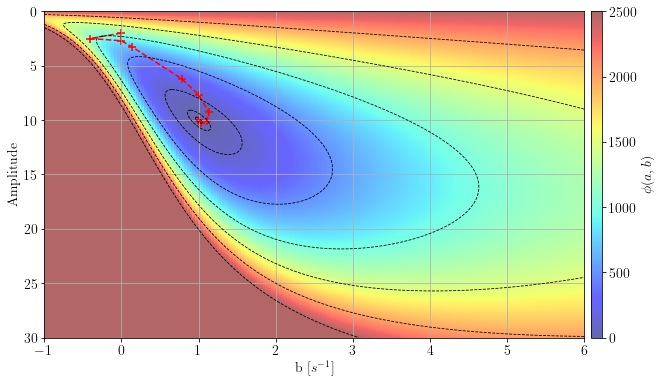

In [11]:
fig, ax = plt.subplots()

im = plt.imshow(obj_l2, clim=(0,2500), extent=[-1., 6., 30., 0.], alpha=.6)
ax.scatter(b_smpld ,a_smpld, color='red' ,s=50, marker="+")
ax.plot(b_smpld, a_smpld, "--", color='red')

ax.set_xlabel("b [$s^{-1}$]")
ax.set_ylabel("Amplitude")

cs = plt.contour(obj_l2,
                 levels=[1., 10., 100., 500., 1000., 1500., 2000., 2500.],
                 extent=[-1., 6., 0., 30.],
                 colors="black", linewidths=(.8,), linestyles='--')

divider = make_axes_locatable(ax)
cbar = plt.colorbar(im, label='$\phi(a,b)$', cax=divider.append_axes("right", size="2%", pad=0.1))

plt.show()

## Variable Projection

Let's try to apply the VarPro method. Therefore, we reduce the number of model parameter to only $b$ because now $a$ is going to be function of $b$. In fact, we can write the new objective function as the following:
\begin{align}
\phi_{VarPro}(b) =  \frac{1}{2} \|\mathbf{y}(a_{opt}(b),b) - \mathbf{y}_{obs} \|_2^2,
\end{align}
where $a_{opt}(b)$ is given by:
\begin{align}
a_{opt}(b) = \frac{\exp(-b\mathbf{t})^{T}\mathbf{y}_{obs}}{\|\exp(-b\mathbf{t})\|_2^2},
\end{align}
which is the minimizer of the following quadratic problem for a fix $b$:
\begin{align}
\phi_{Lin}(a) =  \frac{1}{2} \|a \exp(-b\mathbf{t}) - \mathbf{y}_{obs} \|_2^2.
\end{align}

In [12]:
# Computing optimal a for each b
a_opt = []

for ib, b_value in enumerate(b_samples):
    expb = np.exp(- b_value * time_vec[:])
    a_opt.append(np.dot(expb, data_true[:]) / np.dot(expb, expb))

/var/folders/dt/5j82lw751s7_f33yv8l92zmc0000gn/T/ipykernel_15545/2521546330.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, label='$\phi(a,b)$', cax=divider.append_axes("right", size="2%", pad=0.1))


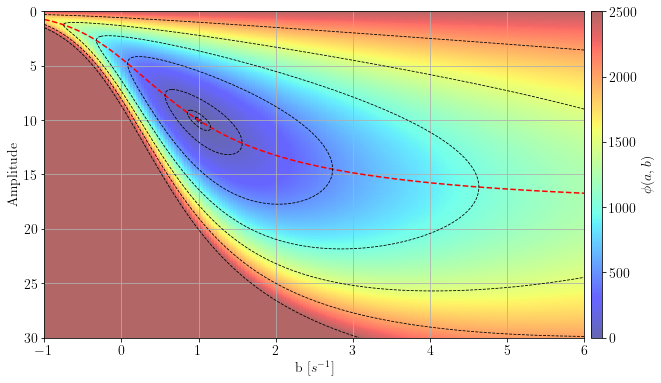

In [13]:
# Looking at the shape of the objective function and the curve along the optimal a
fig, ax = plt.subplots()

im = plt.imshow(obj_l2, clim=(0,2500), extent=[-1., 6., 30., 0.], alpha=.6)
ax.plot(b_samples, a_opt, "--", color='red')

ax.set_xlabel("b [$s^{-1}$]")
ax.set_ylabel("Amplitude")

cs = plt.contour(obj_l2,
                 levels=[1., 10., 100., 500., 1000., 1500., 2000., 2500.],
                 extent=[-1., 6., 0., 30.],
                 colors="black", linewidths=(.8,), linestyles='--')

divider = make_axes_locatable(ax)
cbar = plt.colorbar(im, label='$\phi(a,b)$', cax=divider.append_axes("right", size="2%", pad=0.1))

plt.show()

In [14]:
# Computing the objective function along curve of the optimal a
obj_l2_vp = []
for ib, b_value in enumerate(b_samples):
    model_test[0] = a_opt[ib]
    model_test[1] = b_value
    obj_l2_vp.append(L2_sym.get_obj(model_test))

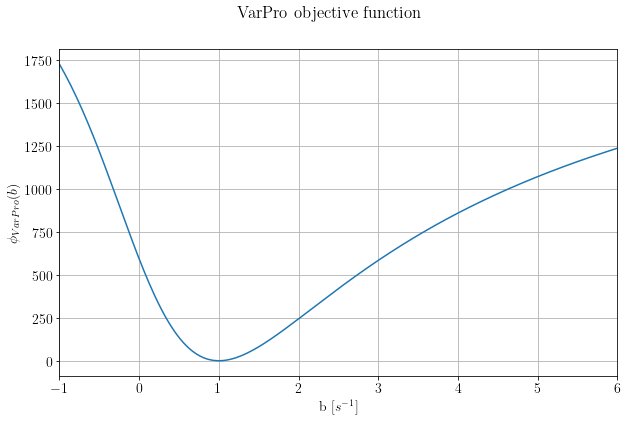

In [15]:
fig, ax = plt.subplots()
ax.plot(b_samples, obj_l2_vp)
ax.set_xlabel("b [$s^{-1}$]"), ax.set_ylabel("$\phi_{VarPro}(b)$")
ax.set_xlim(-1,6)
plt.suptitle("VarPro objective function")
plt.show()

Now let's solve the problem using the variable projection method. First, we need to create some operator to solve the linear problem when we fix the non-linear component of it.

In [16]:
class ExpLinOp(o.Operator):

    def __init__(self, model, t_vec):
        super(ExpLinOp, self).__init__(model, t_vec)
        self.t_samples = t_vec.getNdArray()
        self.nl_model = model.clone()
        return

    def forward(self, add, model, data):
        self.checkDomainRange(model, data)
        b = self.nl_model[0]
        if not add: data.zero()
        data[:] += model[0] * np.exp( - b * self.t_samples)
        return

    def adjoint(self, add, model, data):
        self.checkDomainRange(model, data)
        b = self.nl_model[0]
        if not add: model.zero()
        model[0] += np.sum(data[:] * np.exp( - b * self.t_samples))
        return

    def set_nl(self, nl_model):
        self.nl_model.copy(nl_model)
        return

Secondly, let's create the operator to solve the non-linear problem in the reduced space.

In [17]:
class ExpVarPro(o.Operator):

    def __init__(self, model, t_vec):
        """y(a,b;t) = a * exp(-b*t) """
        super(ExpVarPro, self).__init__(model, t_vec)
        self.t_samples = t_vec.getNdArray()
        self.lin_model = model.clone()
        return

    def forward(self, add, model, data):
        self.checkDomainRange(model, data)
        a = self.lin_model[0]
        b = model[0]
        if not add: data.zero()
        data[:] += a * np.exp( - b * self.t_samples)
        return

    def set_lin(self, lin_model):
        self.lin_model.copy(lin_model)
        return

    
class ExpVarPro_J(o.Operator):

    def __init__(self, model, t_vec):
        super(ExpVarPro_J, self).__init__(model, t_vec)
        self.m0 = model.clone()
        self.lin_model = model.clone()
        self.t_samples = t_vec.getNdArray()
        return

    def forward(self, add, model, data):
        self.checkDomainRange(model, data)
        db = model[0]
        a = self.lin_model[0]
        b0 = self.m0[0]
        if not add: data.zero()
        data[:] += - a * self.t_samples * db * np.exp( - b0 * self.t_samples)
        return

    def adjoint(self, add, model, data):
        self.checkDomainRange(model, data)
        a = self.lin_model[0]
        b0 = self.m0[0]
        if not add: model.zero()
        model[0] -= np.sum(data[:] * a * self.t_samples * np.exp( - b0 * self.t_samples))
        return

    def set_m0(self, m0):
        self.m0.copy(m0)
        return

    def set_lin(self, lin_model):
        self.lin_model.copy(lin_model)
        return

In [18]:
a_init = o.VectorNumpy((1,)).set(a_initial)
b_init = o.VectorNumpy((1,)).set(b_initial)

# Creating non-linear operator
E_vp = ExpVarPro(b_init, time_vec)
E_vp.set_lin(a_init)

# Creating VP operator
E_vp_J = ExpVarPro_J(b_init, time_vec)
E_nl = o.NonlinearOperator(E_vp, E_vp_J, E_vp_J.set_m0)
E_lin = ExpLinOp(a_init, time_vec)
VP_op = o.VarProOperator(E_nl, E_lin, E_lin.set_nl, E_vp_J.set_lin, set_lin=E_vp.set_lin)

# Instantiating VarPro problem object
VPproblem = o.VarProRegularized(b_init, a_init, VP_op, data_true,
                                lin_solver=o.CG(o.BasicStopper(niter=10)))

In [19]:
BFGSsolver.setDefaults(save_obj=True, save_model=True)
t0 = time.time()
BFGSsolver.run(VPproblem, verbose=True)
objVPBFGS = np.copy(BFGSsolver.obj)
print("Computational time %s s" % (time.time() - t0))

# Converting sampled points to arrays for plotting
b_smpld = []
for i in range(len(BFGSsolver.model)):
    b_smpld.append(BFGSsolver.model[i][0])

##########################################################################################
			BFGS SOLVER 

	Restart folder: /tmp/restart_2022-04-16T18-14-16.641109/
##########################################################################################

iter = 0000, obj = 5.92480e+02, rnorm = 3.44e+01, gnorm = 1.18e+03, feval = 1, geval = 1
iter = 0001, obj = 3.29176e+01, rnorm = 8.11e+00, gnorm = 2.00e+02, feval = 8, geval = 8
iter = 0002, obj = 5.12584e+00, rnorm = 3.20e+00, gnorm = 8.84e+01, feval = 9, geval = 9
iter = 0003, obj = 5.71224e-01, rnorm = 1.07e+00, gnorm = 3.20e+01, feval = 10, geval = 10
iter = 0004, obj = 5.02185e-03, rnorm = 1.00e-01, gnorm = 2.94e+00, feval = 11, geval = 11
iter = 0005, obj = 4.00045e-06, rnorm = 2.83e-03, gnorm = 8.31e-02, feval = 12, geval = 12
iter = 0006, obj = 3.00748e-11, rnorm = 7.76e-06, gnorm = 2.28e-04, feval = 13, geval = 13
iter = 0007, obj = 1.78904e-19, rnorm = 5.98e-10, gnorm = 1.76e-08, feval = 14, geval = 14
iter = 0008, obj = 3

In [20]:
# Computing corresponding optimal a
a_smpld = []

for ib, b_value in enumerate(b_smpld):
    expb = np.exp( - b_value * time_vec[:])
    a_smpld.append(np.dot(expb, data_true[:]) / np.dot(expb, expb))

/var/folders/dt/5j82lw751s7_f33yv8l92zmc0000gn/T/ipykernel_15545/1851023474.py:17: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = plt.colorbar(im, label='$\phi(a,b)$', cax=divider.append_axes("right", size="2%", pad=0.1))


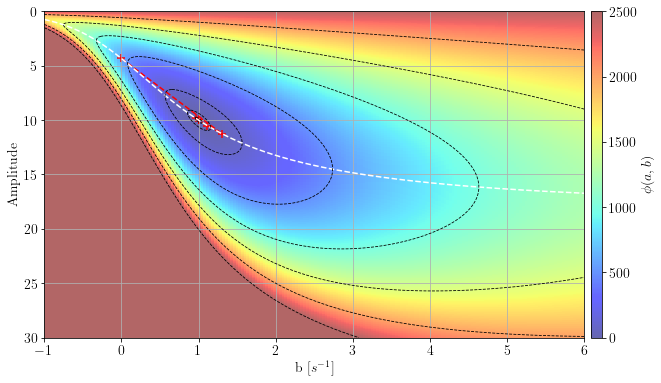

In [21]:
fig, ax = plt.subplots()

im = plt.imshow(obj_l2, clim=(0,2500), extent=[-1., 6., 30., 0.], alpha=.6)
ax.scatter(b_smpld, a_smpld, color='red', s=80, marker="+")
ax.plot(b_smpld, a_smpld, "--", color='red')
ax.plot(b_samples, a_opt, "--", color='white')

ax.set_xlabel("b [$s^{-1}$]")
ax.set_ylabel("Amplitude")

cs = plt.contour(obj_l2,
                 levels=[1., 10., 100., 500., 1000., 1500., 2000., 2500.],
                 extent=[-1., 6., 0., 30.],
                 colors="black", linewidths=(.8,), linestyles='--')

divider = make_axes_locatable(ax)
cbar = plt.colorbar(im, label='$\phi(a,b)$', cax=divider.append_axes("right", size="2%", pad=0.1))

plt.show()

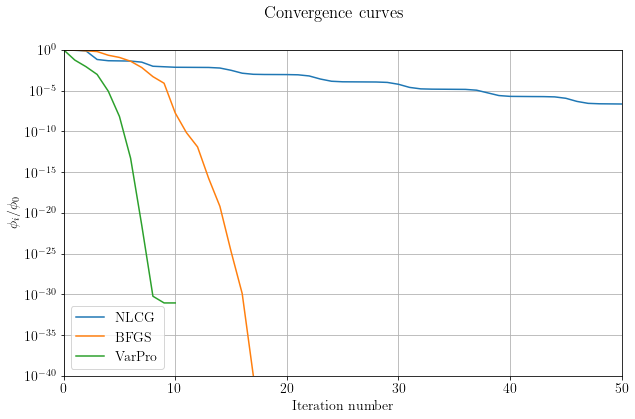

In [22]:
# Plotting convergence curves
fig, ax = plt.subplots()
ax.semilogy((objNLCG   / objNLCG[0]   + 1e-40), label='NLCG')
ax.semilogy((objBFGS   / objBFGS[0]   + 1e-40), label='BFGS')
ax.semilogy((objVPBFGS / objVPBFGS[0] + 1e-40), label='VarPro')

ax.set_xlabel("Iteration number")
ax.set_ylabel(r"$\phi_i/\phi_0$")
ax.legend()
ax.set_xlim(0, 50), ax.set_ylim(1e-40, 1)

plt.suptitle("Convergence curves")
plt.show()

## Solving the same problem with SciPy optimize

Let's now solve the same problem but using the Scipy Optimization module. Compared to SciPy, the modularity of Occamypy provides simple building blocks on which one can construct and solve large-scale optimization problems without too much effort. In this example, we solve a simple optimization problem. But, what if a complex operator formed by multiple functions has to be used to model the data? An example of such a problem, solved using Occamypy is the one described by [Barnier et al. (2018)](https://library.seg.org/doi/10.1190/segam2018-2998613.1). The Occamypy infrastructure allows to seamlessly scale vectors and operators on HPC facilities thanks to the Dask interface. Finally, one limitation of libraries such as SciPy is their inability to handle large-scale vectors (e.g., 1 Tb of data) since they assume the possibility of storing and performing all vector operations in-core fashion. The Occamypy design allows performing all vector/operator computations regardless of the chosen computational paradigm (e.g., local, distributed, in-core, out-of-core).

In [23]:
from scipy.optimize import minimize
        
def objf(x , *args):
    """Objective-function evaluation"""
    temp_data = np.zeros_like(args[1])
    temp_data[:] = x[0] * np.exp(-x[1]*args[1])
    res = temp_data - args[0]
    obj = 0.5 * np.dot(res, res)
    return obj

def der(x, *args):
    """Function to compute objective-function derivative"""
    temp_data = np.zeros_like(args[1])
    tmp_exp = np.exp(-x[1]*args[1])
    temp_data[:] = x[0] * tmp_exp
    res = temp_data - args[0] 
    der = np.zeros_like(x)
    # Computing derivative with respect a and b parameters
    der[0] = np.sum(tmp_exp * res[:])
    der[1] = - np.sum(x[0] * args[1]*tmp_exp * res[:])
    return der

In [24]:
# Let's start by generating the observed data
time_samples = np.linspace(0., 2., 200)
a_true = 10.0
b_true = 1.0
x_true = np.array([a_true, b_true])
data_obs = x_true[0] * np.exp(-x_true[1]*time_samples)

In [25]:
# Now let's create the simple object containing the definition of the inverse problem
x0 = np.array([2.0, 0.0])
res = minimize(objf, x0, args=(data_obs, time_samples), method='BFGS', jac=der, options={'gtol':1e-14,'disp': True})
print("a_opt = ", res.x[0])
print("b_opt = ", res.x[1])

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 14
         Function evaluations: 16
         Gradient evaluations: 16
a_opt =  10.0
b_opt =  1.0


Let's now solve it using the VarPro method.

In [26]:
# Definition of the linear operator of the problem (i.e., a parameter)
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import lsqr

class ExpLinOp_Scipy(LinearOperator):
    def __init__(self, b, t_samples):
        super(ExpLinOp_Scipy, self).__init__(None, (t_samples.shape[0],1))
        self.args = (b, t_samples)

    def _matvec(self, x):
        b = self.args[0]
        t_samples = self.args[1]
        return x[0] * np.exp(-b*t_samples)

    def _rmatvec(self, x):
        b = self.args[0]
        t_samples = self.args[1]
        return np.sum(np.exp(-b*t_samples) * x)

# Definition of the non-linear component of the problem (i.e., b parameter)
def objf_VP(x , *args):
    """Objective-function evaluation using the VarPro method"""
    data = args[0]
    t_samples = args[1]
    temp_data = np.zeros_like(t_samples)
    b = x[0]
    # Solving linear problem for a fixed b = x[0]
    linOp = ExpLinOp_Scipy(b, t_samples)
    linOp.matvec([1.0])
    a_opt = lsqr(linOp, data, atol=1e-12, btol=1e-12)
    args[2][:] = a_opt[0]    
    temp_data[:] = args[2] * np.exp(-b*t_samples)
    res = temp_data - data
    obj = 0.5 * np.dot(res, res)
    return obj

def der_VP(x, *args):
    """Function to compute objective-function derivative"""
    data = args[0]
    t_samples = args[1]
    a_opt = args[2] 
    temp_data = np.zeros_like(t_samples)
    tmp_exp = np.exp(-x[0]*t_samples)
    temp_data[:] = a_opt * tmp_exp
    res = temp_data - data
    der = np.zeros_like(x)
    # Computing derivative with respect a and b parameters
    der[0] = - np.sum(a_opt * t_samples * tmp_exp * res[:])
    return der

In [27]:
# Now let's create the simple object containing the definition of the inverse problem
x0 = np.array([0.0])
a_opt = np.array([0.0])
res = minimize(objf_VP, x0, args=(data_obs, time_samples, a_opt), method='BFGS', jac=der_VP, 
               options={'gtol' : 1e-23, 'disp': True})
print("a_opt = ", a_opt)
print("b_opt = ", res.x[0])

         Current function value: 0.000000
         Iterations: 7
         Function evaluations: 9
         Gradient evaluations: 9
a_opt =  [10.]
b_opt =  0.9999999999999993


Just like OccamyPy, the two implemented optimization processes using SciPy achieve the correct solution. However, all the operations are performed on a single machine and only within the CPU and strictly using an in-core fashion. In addition, as previously mentioned, if the optimization workflow requires the ability to quickly test multiple combined operators, its SciPy implementation may potentially be cumbersome and hardly applicable to HPC environments. The OccamyPy library allows to easily combine multiple operators to define a problem to be solved using the VarPro method. An example of such a case can be seen in the code written by Barnier et al. (2018) [FWIME main](https://github.com/gbarnier/acoustic_isotropic_operators/blob/master/acoustic_iso_lib/python/python_float/fwimeMain.py).